In [34]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

In [35]:
concepts = pd.read_json('../data/dictionary.json').T['label']

In [36]:
from datasets import load_dataset
""" ...We split EURLEX57K into training (45k documents), development (6k), and test subsets (6k) ..."""
train = load_dataset('eurlex', 'eurlex57k', split='train')
test = load_dataset('eurlex', 'eurlex57k', split='test')
val = load_dataset('eurlex', 'eurlex57k', split='validation')
len(train), len(test), len(val)

Reusing dataset eurlex (/Users/albina-volk/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)
Reusing dataset eurlex (/Users/albina-volk/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)
Reusing dataset eurlex (/Users/albina-volk/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)


(45000, 6000, 6000)

In [37]:
def ohe(dataset):
    one_hot = MultiLabelBinarizer()
    labels = dataset['eurovoc_concepts']
    ohe = pd.DataFrame(one_hot.fit_transform(labels).T, index=one_hot.classes_)
    ohe = pd.merge(concepts, ohe, left_index=True, right_index=True)
    ohe.index = ohe['label']
    ohe = ohe.drop('label', axis=1)
    ohe = ohe.T
    return ohe

In [38]:
ohe_train = ohe(train)
ohe_val = ohe(val)
ohe_test = ohe(test)
all_documents = pd.concat([ohe_train, ohe_val, ohe_test]).fillna(0)
ohe_train = all_documents[:45000]
ohe_val = all_documents[45000:51000]
ohe_test = all_documents[51000:]

In [39]:
""" ...in EURLEX57K, from which only 2,049 (47.97%) have been assigned to more than 10 documents... """
(all_documents.sum() >= 10).sum(), (all_documents.sum() >= 10).sum() / len(all_documents.columns)

(2049, 0.47974713181924605)

In [40]:
"""...We also divide the 4,271 labels into frequent (746), few-shot (3,362), and zero-shot (163), depending on whether they were
assigned to more than 50, fewer than 50 but at least one, or no training documents, respectively..."""
print(f"frequent: {(ohe_train.sum() >= 50).sum()}")
print(f"few-shot: {(ohe_train.sum() > 0).sum() - (ohe_train.sum() >= 50).sum()}")
print(f"zero-shot: {(ohe_train.sum() == 0).sum()}")

frequent: 746
few-shot: 3362
zero-shot: 163


<AxesSubplot:>

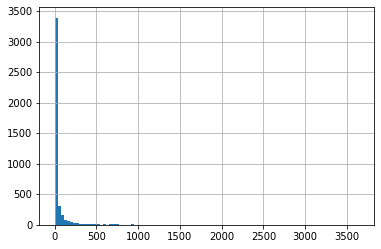

In [41]:
ohe_train.sum().hist(bins=100)

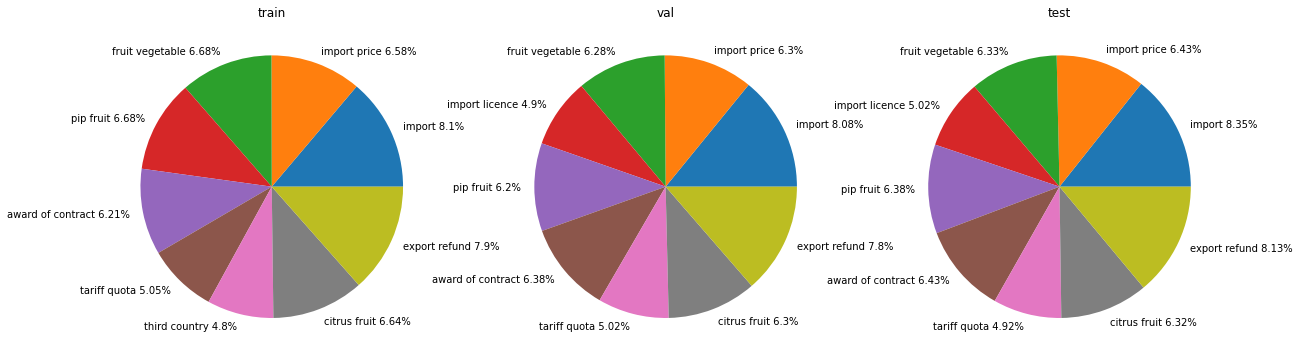

In [47]:

fig, axs = plt.subplots(1, 3, figsize=[20, 10])
l = [ohe_train, ohe_val, ohe_test]
names = ['train', 'val', 'test']
for i, x in enumerate(l):
    counts = x.sum()
    axs[i].pie(x=counts.values[counts > counts.sort_values()[-10]],
                         labels=counts.index[counts > counts.sort_values()[-10]] + " " + (counts.values[counts > counts.sort_values()[-10]] / len(x) * 100).round(2).astype(str) + "%",
                        #  normalize=True, textprops={"fontsize":15},
                        #  colors=colors[[x in labels[remp.iloc[i] > 0.1] for x in super_set]]
                        )
    axs[i].set_title(f'{names[i]}')
plt.show()

In [58]:
normed = ohe_train.T/ohe_train.sum(axis=1)
penetration_matrix_train = normed @ normed.T

In [69]:
label_name = 'Lithuania'
penetration_matrix_train.sort_values(label_name)[label_name][::-1][:10]

label
Lithuania                            4.980342
Latvia                               0.602101
originating product                  0.593888
Estonia                              0.535497
veterinary inspection                0.472428
European Committee of the Regions    0.444444
appointment of staff                 0.444444
product designation                  0.390532
import                               0.373016
fishing area                         0.336849
Name: Lithuania, dtype: float64